In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Now we show the interface with `kwant`. We start by using `kwant` to build two tight-binding systems with translational symmetry:
* graphene;
* a dummy `kwant.Builder` that encodes the interaction matrix.
See [`kwant_examples`](./codes/kwant_examples.py) to verify how these two steps are done.

In [2]:
def flat_to_matrix(flat, shape):
    matrix = np.zeros(shape, dtype=complex)
    matrix[:, :, *np.triu_indices(shape[-1])] = flat.reshape(shape[0], shape[1], -1)
    lower_triangle_wo_diag = matrix.transpose(0, 1, 3, 2)[
        :, :, *np.tril_indices(shape[-1], k=-1)
    ]
    matrix[:, :, *np.tril_indices(shape[-1], k=-1)] = lower_triangle_wo_diag.reshape(
        shape[0], shape[1], -1
    ).conj()

    return matrix

def matrix_to_flat(matrix):
    matrix[
        :,
        :,
        *np.triu_indices(matrix.shape[-1]),
    ].flatten()

def upper_triangle_cost(delta_mf_flatten, model):
    mfk_shape = model.mf_k.shape

    # From flat to non-flat:
    mf_delta_shaped = flat_to_matrix(delta_mf_flatten, mfk_shape)

    # Doing the update
    mf_shaped = model.mf_k + mf_delta_shaped
    _, model.mf_k = hf.updated_matrices(mf_k=mf_shaped, model=model)
    delta_mf = mf_shaped - model.mf_k

    # Now flattening again
    return matrix_to_flat(delta_mf)

In [3]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We then use `utils.builder2tb_model` to parse the `kwant.Builder` to a `tb_model` that we will use in the self-consistent calculations.

In [4]:
tb_model = utils.builder2tb_model(graphene_builder)

Note that the self-consistent loop is performed on a coarse k-point grid, and thus not necessarily appropriate to compute observables. We thus use `utils.kgrid_hamiltonian` to evaluate the Hamiltonian on a denser k-point grid and compute the gap.

In [12]:
params = dict(U=1, V=1)
int_model = utils.builder2tb_model(int_builder, params)
model = hf.Model(tb_model, int_model=int_model)
vectors = utils.generate_vectors(10, model.dim)
model.vectors = [*vectors, *model.tb_model.keys()]
model.random_guess(model.vectors)
model.kgrid_evaluation(nk=15)
matrix_to_flat(model.mf_k)

In [5]:
def compute_gap(
    model,
    nk,
    nk_dense,
    filling=2,
    guess=None,
):

    model.guess = guess

    # Find groundstate Hamiltonian on the same grid
    mf_model = hf.find_groundstate_ham(
        model,
        filling=filling,
        nk=nk,
        cutoff_Vk=10,  # no intuition about cutoff_Vk
        cost_function=upper_triangle_cost,
    )

    mf_k = utils.kgrid_hamiltonian(  # only used for diagonalization to get gap
        nk=nk_dense,
        hk=utils.model2hk(tb_model=mf_model),
        dim=2
    )
    # Diagonalize groundstate Hamiltonian
    vals, _ = np.linalg.eigh(mf_k)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)

    # the guess was kind of unclear
    return gap, mf_model

Finally, we also parse `int_builder` with the wanted interaction strength. Note that we pass a `params` dictionary to evaluate the Hamiltonian with `kwant`.

In [6]:
def compute_phase_diagram(Us, Vs, nk, nk_dense):
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:
            params = dict(U=U, V=V)
            int_model = utils.builder2tb_model(int_builder, params)
            model = hf.Model(tb_model, int_model=int_model)
            _gap, guess = compute_gap(
                model=model,
                nk=nk,
                nk_dense=nk_dense,
                guess=guess,
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

**Warning:** this phase diagram calculation takes about one hour.

In [14]:
# Generate dense-grid k-points
# Interaction strengths
nk = 15
nk_dense = 30
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, nk=nk, nk_dense=nk_dense)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 1 into shape (15,15,newaxis)

In [15]:
%debug

> /var/folders/yf/2jcxwgld3l77h6y62fb5ty8ssr_5lq/T/ipykernel_80069/2781680018.py(3)flat_to_matrix()
      1 def flat_to_matrix(flat, shape):
      2     matrix = np.zeros(shape, dtype=complex)
----> 3     matrix[:, :, *np.triu_indices(shape[-1])] = flat.reshape(shape[0], shape[1], -1)
      4     lower_triangle_wo_diag = matrix.transpose(0, 1, 3, 2)[
      5         :, :, *np.tril_indices(shape[-1], k=-1)

> /var/folders/yf/2jcxwgld3l77h6y62fb5ty8ssr_5lq/T/ipykernel_80069/2781680018.py(24)upper_triangle_cost()
     22 
     23     # From flat to non-flat:
---> 24     mf_delta_shaped = flat_to_matrix(delta_mf_flatten, mfk_shape)
     25 
     26     # Doing the update

array(nan)
> /Users/rzijderveld/opt/anaconda3/envs/python3/lib/python3.11/site-packages/scipy/optimize/_nonlin.py(168)func()
    166     x0 = _as_inexact(x0)
    167     def func(z):
--> 168         return _as_inexact(F(_array_like(z, x0))).flatten()
    169     x = x0.flatten()
    170 

array([nan])
array(nan)
> /Users/

In [45]:
import xarray as xr

gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

We note that the gap openings coincide with the phase transitions from gapless to charge density wave or antiferromagnetic groundstates as predicted in [arXiv:1204.4531](https://arxiv.org/abs/1204.4531). 

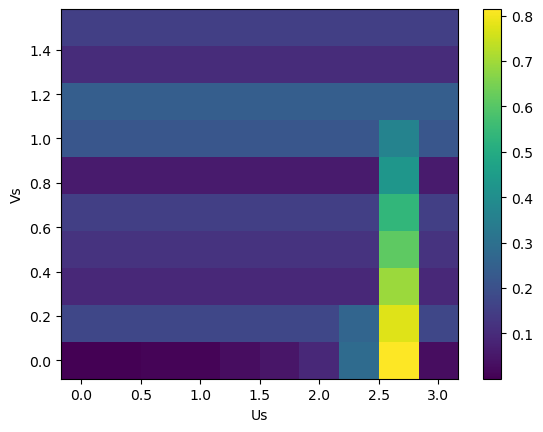

In [46]:
gap_da.plot(x="Us", y="Vs")

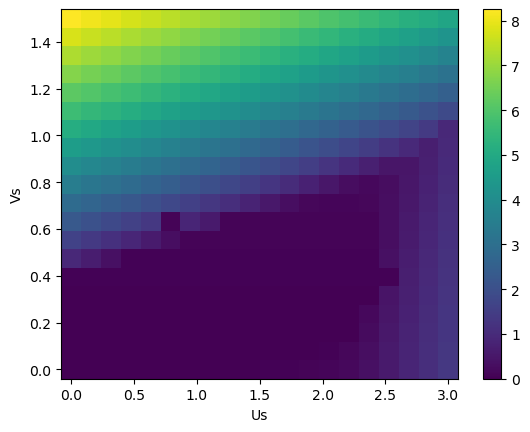

In [8]:
gap_da.plot(x="Us", y="Vs")

In [9]:
gap_da.to_netcdf("./data/graphene_example.nc")